In [15]:
import statsapi
import pandas as pd


## Preprocessing

In [16]:
players = pd.read_csv("mlb_players_2021.csv")
pitches = pd.read_csv("regseason.csv")

In [18]:
players.rename(columns={"id" : "batter","fullName" : "batter_fullName" , "birthCountry" : "batter_birthCountry"}, inplace=True)
players.head()

,batter,batter_fullName,birthDate,batter_birthCountry,height,weight,primaryPosition,batSide,pitchHand,debutDate,active
0,642758,Domingo Acevedo,1994-03-06,Dominican Republic,"6' 7""",240,P,R,R,2021-06-21,True
1,664119,Austin Allen,1994-01-16,USA,"6' 1""",219,C,L,R,2019-05-11,False
2,462101,Elvis Andrus,1988-08-26,Venezuela,"6' 0""",210,SS,R,R,2009-04-06,False
3,642456,Luis Barrera,1995-11-15,Dominican Republic,"6' 0""",195,OF,L,L,2021-05-19,True
4,605135,Chris Bassitt,1989-02-22,USA,"6' 5""",217,P,R,R,2014-08-30,True


In [19]:
# Merge pitches df with info about the batter
full_df = pd.merge(pitches, players[["batter","batter_fullName","batSide", "batter_birthCountry"]], on="batter")
full_df.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,count,PBhand,pitch_cat,batter_fullName,batSide,batter_birthCountry
0,1,SL,2021-10-03,85.1,2.39,6.05,"Detmers, Reid",641487,672282,single,...,Standard,293.0,0.079,0.780,0_1,bLpL,breaking,J.P. Crawford,L,USA
1,2,FF,2021-10-03,93.8,2.31,6.03,"Detmers, Reid",641487,672282,NaN,...,Standard,150.0,0.000,-0.045,0_0,bLpL,fastball,J.P. Crawford,L,USA
2,3,CU,2021-10-03,73.9,2.12,6.25,"Detmers, Reid",664238,672282,strikeout,...,Standard,329.0,-0.032,-0.315,2_2,bRpL,breaking,Dylan Moore,R,USA
3,4,FF,2021-10-03,94.6,2.43,5.96,"Detmers, Reid",664238,672282,NaN,...,Standard,146.0,0.000,0.047,1_2,bRpL,fastball,Dylan Moore,R,USA
4,5,FF,2021-10-03,94.3,2.08,6.15,"Detmers, Reid",664238,672282,NaN,...,Standard,151.0,0.000,0.000,1_2,bRpL,fastball,Dylan Moore,R,USA


In [21]:
# Remove the pitches that were fouled, in play, or swung at
not_hit = ["called_strike", "ball"]
pitches_not_hit = full_df[full_df['description'].isin(not_hit)].copy()
len(pitches_not_hit)
pitches_not_hit.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,count,PBhand,pitch_cat,batter_fullName,batSide,batter_birthCountry
2,3,CU,2021-10-03,73.9,2.12,6.25,"Detmers, Reid",664238,672282,strikeout,...,Standard,329.0,-0.032,-0.315,2_2,bRpL,breaking,Dylan Moore,R,USA
3,4,FF,2021-10-03,94.6,2.43,5.96,"Detmers, Reid",664238,672282,NaN,...,Standard,146.0,0.000,0.047,1_2,bRpL,fastball,Dylan Moore,R,USA
6,7,FF,2021-10-03,94.2,2.33,5.94,"Detmers, Reid",664238,672282,NaN,...,Standard,145.0,0.000,0.032,0_1,bRpL,fastball,Dylan Moore,R,USA
9,10,CU,2021-10-03,73.9,2.22,6.23,"Detmers, Reid",663728,672282,NaN,...,Standard,322.0,0.000,0.174,2_2,bRpL,breaking,Cal Raleigh,S,USA
12,13,FF,2021-10-03,94.4,2.48,5.97,"Detmers, Reid",663728,672282,NaN,...,Standard,148.0,0.000,0.062,1_2,bRpL,fastball,Cal Raleigh,S,USA


In [22]:
pitches_not_hit["strike_zone"] = pitches_not_hit["zone"] <= 9 # Determine if the pitch was actually in the zone

pitches_not_hit["called_correctly"] = (
    ((pitches_not_hit["zone"] <= 9) & (pitches_not_hit["type"] == "S")) | # Pitch is in the zone and is called a strike  
    ((pitches_not_hit["zone"] > 9) & (pitches_not_hit["type"] == "B"))    # Pitch is not in the zone and is called a ball
) 
pitches_not_hit["called_correctly"] = pitches_not_hit["called_correctly"].astype(int) # This will be are target variable -- whether the pitch was called "correctly"

In [23]:
pitches_not_hit["babip_value"].unique()

array([ 0., nan])

In [24]:
pitches_not_hit["iso_value"].unique()

array([ 0., nan])

## New addition

In [25]:
# Creating a new variable to see if a game altering event (out or man on base) came as a result of the pitch
pitches_not_hit['has_event'] = pitches_not_hit['events'].notna().astype(int) 

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

y = pitches_not_hit["called_correctly"]
X= pitches_not_hit.drop(["called_correctly"], axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.head()

# Combining into a new df
train_df = X_train.copy()
train_df['target'] = y_train

# Split into correct/incorrect
majority = train_df[train_df['target'] == 1]  # Correct calls
minority = train_df[train_df['target'] == 0]  # Incorrect calls

# Downsample majority
majority_downsampled = resample(
    majority, replace=False,# nso replacement
    n_samples=len(minority),#Match number of minority examples
    random_state=123)

#Combine back
train_balanced = pd.concat([majority_downsampled, minority])
train_balanced = train_balanced.sample(frac=1, random_state=123).reset_index(drop=True)

# Set up x and y train balanced
X_train_balanced = train_balanced.drop(columns=['target'])
y_train_balanced = train_balanced['target']

In this code chunk, I set up X and y train, but balance the datasets so there are an equal number of correct and incorrectly called pitches so the model doesn't just predict pitches called correctly

### 2 Quantitive, One Qualitative

In [31]:
all_quant_cols = [  # only numerical features that don't show where the pitch ends up
    'release_speed', 'release_pos_x', 'release_pos_z','balls', 'strikes',
    'outs_when_up', 'inning',
    'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate', 'release_extension',
    'release_pos_y', 'at_bat_number', 'pitch_number', 'home_score', 'away_score', 'bat_score',
    'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score',
    'post_fld_score', 'spin_axis', 'delta_run_exp', 'delta_home_win_exp', 'has_event' #took out zone
]

all_qual_cols = [ # only qualitiative features that don't show where the pitch ends up
    'pitch_type', 'game_date', 'player_name', 'events', 'description', 'des', 'game_type',
 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'inning_topbot', 'pitch_name',
 'if_fielding_alignment', 'of_fielding_alignment', 'count', 'PBhand', 'pitch_cat', 
 'batter_fullName', 'batSide', 'batter_birthCountry' #took out strike zone
]


In [32]:
# two quant, one qual
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import random

random.seed(123)
best_score = 0
best_cols = []

min_datapoints = 500
# Total number of combinations
total_combos = len(all_qual_cols) * len(list(combinations(all_quant_cols, 2)))

# Initialize progress bar
with tqdm(total=total_combos, desc="Evaluating combinations") as pbar:
    for qual in all_qual_cols:
        for pair in combinations(all_quant_cols, 2): 
            cols = list(pair) + [qual]  # use just the current qualitative column
            try:
                # Drop rows with NaNs in selected columns only
                X_sub = X_train_balanced[cols].dropna()
                y_sub = y_train_balanced.loc[X_sub.index]

                if len(X_sub) < min_datapoints:
                    continue

                LR = LogisticRegression()
                LR.fit(X_sub, y_sub)
                score = LR.score(X_sub, y_sub)

                if score > best_score:
                    best_score = score
                    best_cols = cols
                    print(f"\n New best score: {best_score:.4f} with features: {best_cols}")
            except KeyError:
                pass
            except ValueError:
                pass
            finally:
                pbar.update(1)

Evaluating combinations:  73%|███████▎  | 6958/9570 [00:49<00:18, 143.31it/s]


 New best score: 0.5211 with features: ['release_speed', 'release_pos_x', 'count']

 New best score: 0.5476 with features: ['release_speed', 'balls', 'count']

 New best score: 0.5478 with features: ['release_speed', 'strikes', 'count']


Evaluating combinations:  73%|███████▎  | 6973/9570 [00:50<00:55, 46.49it/s] 


 New best score: 0.5478 with features: ['release_speed', 'pitch_number', 'count']


Evaluating combinations:  73%|███████▎  | 6984/9570 [00:51<01:15, 34.07it/s]


 New best score: 0.6440 with features: ['release_speed', 'delta_run_exp', 'count']


Evaluating combinations:  73%|███████▎  | 7019/9570 [00:52<01:45, 24.28it/s]


 New best score: 0.6490 with features: ['release_pos_x', 'delta_run_exp', 'count']


Evaluating combinations:  75%|███████▍  | 7165/9570 [00:59<01:35, 25.14it/s]


 New best score: 0.6492 with features: ['vx0', 'delta_run_exp', 'count']


Evaluating combinations: 100%|██████████| 9570/9570 [01:27<00:00, 109.43it/s]


In [33]:
print(best_cols)
print(best_score)

['vx0', 'delta_run_exp', 'count']
0.6492287333030065


The best columns I find are pitch number, the total number of at pitches thrown in an at bat, delta_run_exp, the change in run expentency before and after the pitch, and strike zone, depicting if a pitch is called correctly or not.

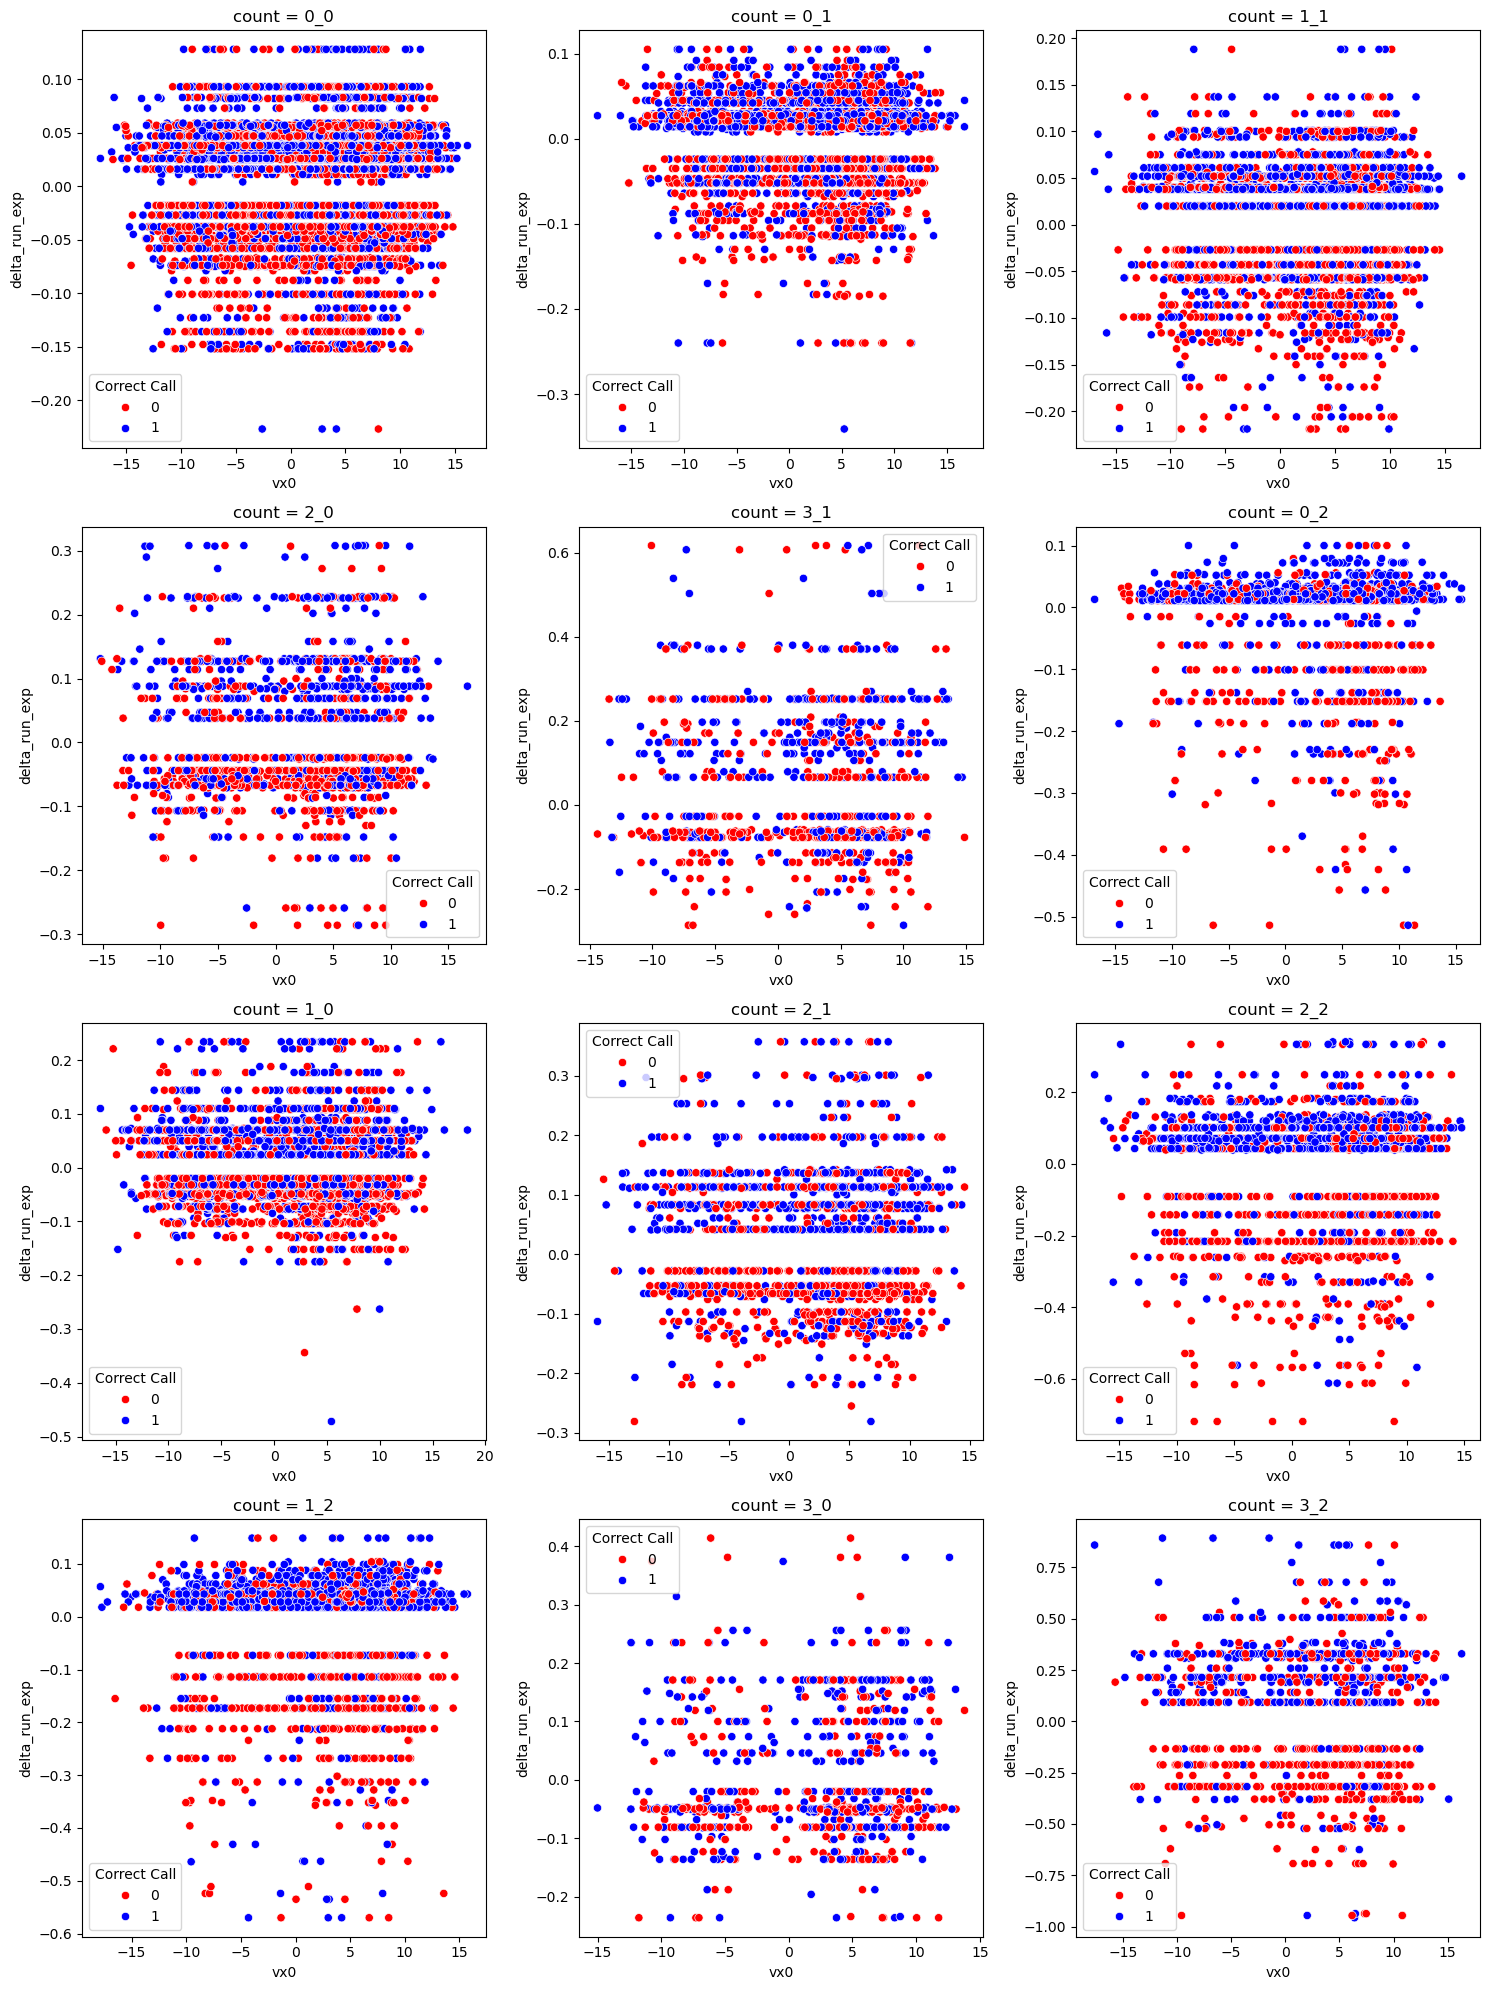

In [34]:
# visualizing model

import matplotlib.pyplot as plt
import seaborn as sns


quant1, quant2, qual = best_cols  # Unpack

# Set up the full dataframe
plot_df = X_train_balanced[[quant1, quant2, qual]].copy()
plot_df['target'] = y_train_balanced.values  # Add back the target

# Unique categories in the qualitative variable
categories = plot_df[qual].dropna().unique()

# Set up subplots
n_categories = len(categories)
n_cols = 3
n_rows = (n_categories + n_cols - 1) // n_cols  # rounds up
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5), squeeze=False)

# Plot each category
for idx, category in enumerate(categories):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]

    # Filter only this category
    cat_df = plot_df[plot_df[qual] == category]

    # Scatterplot
    sns.scatterplot(
        data=cat_df,
        x=quant1,
        y=quant2,
        hue='target',
        palette={0: 'red', 1: 'blue'},
        ax=ax
    )

    ax.set_title(f"{qual} = {category}")
    ax.legend(title="Correct Call", loc='best')

# Hide unused subplots
for idx in range(len(categories), n_rows*n_cols):
    row = idx // n_cols
    col = idx % n_cols
    axes[row][col].axis('off')

plt.tight_layout()
plt.show()


### Takeaways
 While the accuracy is slightly better than 50%, it isn't much (65%), so we need to play around with using other models. The 3 features the model used are velocity in the x position, delta run exp: the increase/decrease in percent of scoring for an at bat and the count.

## Downsampling and Creation of Train and Test Sets for Full Model

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

y = pitches_not_hit["called_correctly"]
X= pitches_not_hit.drop(["called_correctly"], axis= 1)


# Combining into a new df
X_df = X.copy()
X_df['target'] = y

# Split into correct/incorrect
majority = X_df[X_df['target'] == 1]  # Correct calls
minority = X_df[X_df['target'] == 0]  # Incorrect calls

# Downsample majority
majority_downsampled = resample(
    majority,
    replace=False,# No replacement
    n_samples=len(minority),# Match number of minority examples
    random_state=42
)

#Combine back
balanced = pd.concat([majority_downsampled, minority])
balanced = balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Set up x and y train balanced
X_balanced = balanced.drop(columns=['target'])
y_balanced = balanced['target']

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced)
X_train.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,delta_home_win_exp,delta_run_exp,count,PBhand,pitch_cat,batter_fullName,batSide,batter_birthCountry,strike_zone,has_event
45668,362825,FC,2021-06-08,84.3,2.76,5.73,"Lester, Jon",670764,452657,NaN,...,0.0,-0.049,0_0,bRpL,fastball,Taylor Walls,S,USA,True,0
23642,669377,KC,2021-06-06,79.2,-1.67,6.30,"Cease, Dylan",668731,656302,NaN,...,0.0,-0.052,0_1,bLpR,breaking,Akil Baddoo,L,USA,False,0
46878,456334,SL,2021-06-22,78.2,-1.36,5.22,"Crick, Kyle",660162,605195,NaN,...,0.0,-0.027,0_0,bLpR,breaking,Yoán Moncada,S,Cuba,True,0
62765,369518,FF,2021-04-16,97.1,-2.84,5.38,"Hudson, Daniel",656976,543339,NaN,...,0.0,0.013,0_2,bLpR,fastball,Pavin Smith,L,USA,False,0
27147,362087,FF,2021-06-14,90.8,2.87,5.71,"Lester, Jon",607732,452657,NaN,...,0.0,-0.045,0_0,bRpL,fastball,Jacob Stallings,R,USA,True,0


## Full LR model

In [76]:
all_quant_cols_fm = [  
    'release_speed', 'release_pos_x', 'release_pos_z', 'zone', 'balls', 'strikes',
    'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'outs_when_up', 'inning',
    'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate', 'release_extension',
    'release_pos_y', 'at_bat_number', 'pitch_number', 'home_score', 'away_score', 'bat_score',
    'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score',
    'post_fld_score', 'spin_axis', 'delta_run_exp', 'delta_home_win_exp', 'has_event'
]

all_qual_cols_fm = [
    'pitch_type', 'game_date', 'player_name', 'events', 'description', 'des', 'game_type',
 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'inning_topbot', 'pitch_name',
 'if_fielding_alignment', 'of_fielding_alignment', 'count', 'PBhand', 'pitch_cat', 
 'batter_fullName', 'batSide', 'batter_birthCountry', 'strike_zone'
]


I use the one-hot-encoder in the model to pre-process the data for all the qualitative columns.

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import random

random.seed(123)
qual_cols = all_qual_cols_fm
quant_cols = all_quant_cols_fm

#preprocessing for numeric and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', quant_cols),
        ('cat', Pipeline([
        ('encoder', OneHotEncoder(handle_unknown= 'ignore'))]), qual_cols) 
    ]
)

# Combine preprocessor with a logistic regression model
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))])

#Cleaning out rows with NaNs and re-fitting y to match
X_train_clean = X_train[quant_cols+ qual_cols].dropna() # so we don't have NA errors
y_train_clean = y_train.loc[X_train_clean.index]

X_test_clean = X_test[quant_cols + qual_cols].dropna()
y_test_clean = y_test.loc[X_test_clean.index]

# fit model on training set
clf.fit(X_train_clean, y_train_clean) 

# Evaluate on both training and test sets
train_score = accuracy_score(y_train_clean, clf.predict(X_train_clean))
test_score = accuracy_score(y_test_clean, clf.predict(X_test_clean))

print(f" Training Accuracy: {train_score:.4f}")
print(f" Test Accuracy: {test_score:.4f}")

 Training Accuracy: 0.7253
 Test Accuracy: 0.6986


/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now, evaluating the model on all features, we see a testing and training accuracy of around 72%, which is pretty solid. This is higher than any of the models where we only selected a handful of features. I would be impressed if we could do better because that would mean that there are certain features that umpires are biased towards. The next step is to look at which features have the biggest values.

In [84]:
# Get the ecoded column names
ohe = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
ohe_feature_names = ohe.get_feature_names_out(qual_cols)

#combine numeric and encoded categorical feature names
feature_names = quant_cols + list(ohe_feature_names)

# Collect matching coefficents
coefficients = clf.named_steps['classifier'].coef_[0]


In this code chunk, I create two lists, one of the feature names and one of the coefficients, with matching indices so i can graph it.

/var/folders/gx/d6zl9l4908q7p_vk4j3x06x00000gn/T/ipykernel_30589/1884623878.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Feature', data=coef_df_sorted, palette='coolwarm')


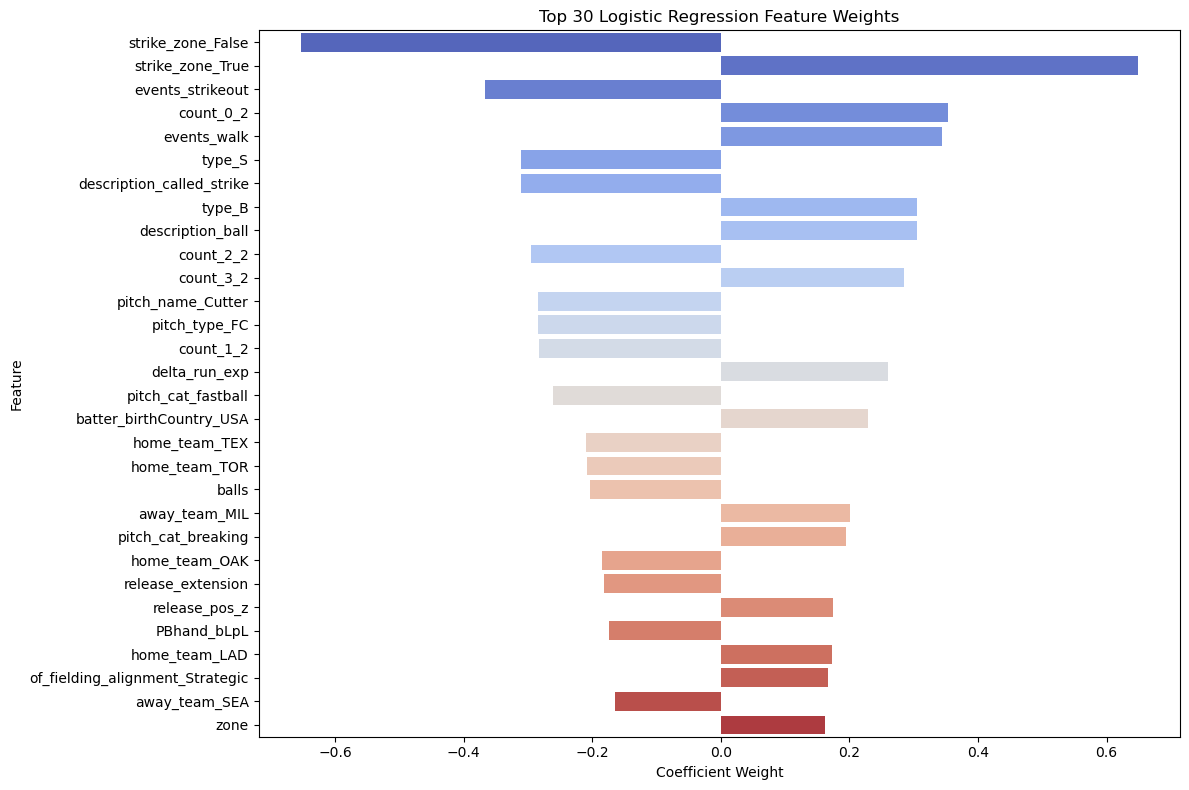

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Put coefficients into a DataFrame
coef_df=pd.DataFrame({
    'Feature': feature_names,
    'Weight': coefficients})

# Sort by absolute value weight
coef_df['abs_weight']= coef_df['Weight'].abs()
coef_df_sorted = coef_df.sort_values(by='abs_weight', ascending=False).head(30)  # top 30 most important

#Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Weight', y='Feature', data=coef_df_sorted, palette='coolwarm')
plt.title('Top 30 Logistic Regression Feature Weights')
plt.xlabel('Coefficient Weight')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

This graph visualizes the top 30 features with the highest weights. The most important is strike zone, but digging into the list we can see there are some suprising features we wouldn't expect to have an impact, like some home/away teams and that players from the DR bring down the probablity of a pitch called correctly while players in the USA bring it up.

## Full LR Model With Just Pitch Info
Here I re-run the same model as above but I take out any information about the pitch itself and then any about player demographics or team so we can audit for bias.

In [86]:
all_quant_cols_pi = [  # only numerical features that don't show where the pitch ends up
    'release_speed', 'release_pos_x', 'release_pos_z','balls', 'strikes',
    'outs_when_up', 'inning',
    'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate', 'release_extension',
    'release_pos_y', 'at_bat_number', 'pitch_number', 'home_score', 'away_score', 'bat_score',
    'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score',
    'post_fld_score', 'spin_axis', 'delta_run_exp', 'delta_home_win_exp', 'has_event' #took out zone
]

all_qual_cols_pi = [ # only qualitiative features that don't show where the pitch ends up
    'pitch_type', 'game_date', 'events', 'description', 'des', 'game_type',
 'stand', 'p_throws', 'type', 'inning_topbot', 'pitch_name',
 'if_fielding_alignment', 'of_fielding_alignment', 'count', 'PBhand', 'pitch_cat', 
  'batSide',  #took out strike zone
]

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import random

random.seed(123)
qual_cols = all_qual_cols_pi
quant_cols = all_quant_cols_pi

#preprocessing for numeric and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', quant_cols),
        ('cat', Pipeline([
        ('encoder', OneHotEncoder(handle_unknown= 'ignore'))]), qual_cols) 
    ]
)

# Combine preprocessor with a logistic regression model
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))])

#Cleaning out rows with NaNs and re-fitting y to match
X_train_clean = X_train[quant_cols+ qual_cols].dropna() # so we don't have NA errors
y_train_clean = y_train.loc[X_train_clean.index]

X_test_clean = X_test[quant_cols + qual_cols].dropna()
y_test_clean = y_test.loc[X_test_clean.index]

# fit model on training set
clf.fit(X_train_clean, y_train_clean) 

# Evaluate on both training and test sets
train_score = accuracy_score(y_train_clean, clf.predict(X_train_clean))
test_score = accuracy_score(y_test_clean, clf.predict(X_test_clean))

print(f" Training Accuracy: {train_score:.4f}")
print(f" Test Accuracy: {test_score:.4f}")

 Training Accuracy: 0.7023
 Test Accuracy: 0.7051


/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [88]:
# Get the ecoded column names
ohe = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
ohe_feature_names = ohe.get_feature_names_out(qual_cols)

#combine numeric and encoded categorical feature names
feature_names = quant_cols + list(ohe_feature_names)

# Collect matching coefficents
coefficients = clf.named_steps['classifier'].coef_[0]


/var/folders/gx/d6zl9l4908q7p_vk4j3x06x00000gn/T/ipykernel_30589/1884623878.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Feature', data=coef_df_sorted, palette='coolwarm')


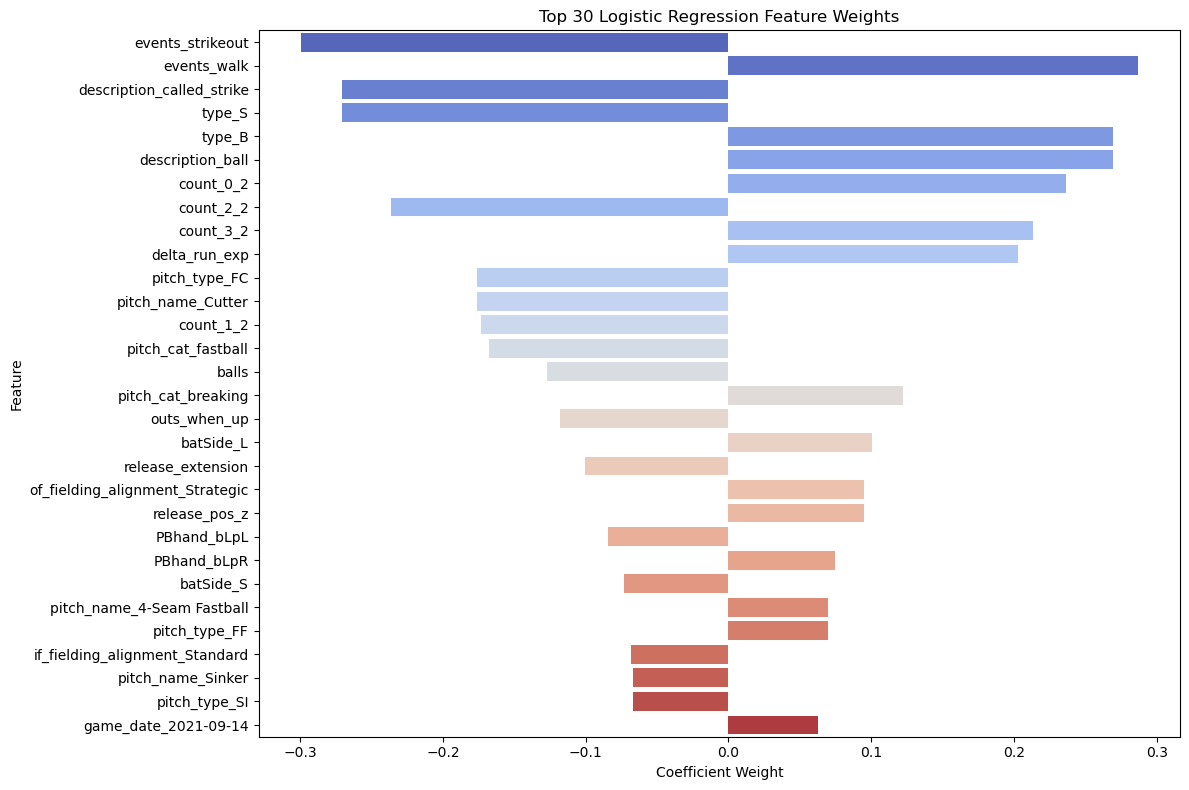

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Put coefficients into a DataFrame
coef_df=pd.DataFrame({
    'Feature': feature_names,
    'Weight': coefficients})

# Sort by absolute value weight
coef_df['abs_weight']= coef_df['Weight'].abs()
coef_df_sorted = coef_df.sort_values(by='abs_weight', ascending=False).head(30)  # top 30 most important

#Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Weight', y='Feature', data=coef_df_sorted, palette='coolwarm')
plt.title('Top 30 Logistic Regression Feature Weights')
plt.xlabel('Coefficient Weight')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()